In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_covid_1 = pd.read_csv("HIST_PAINEL_COVIDBR_2021_Parte2_30mar2022.csv", sep=';', encoding = 'utf8')
df_covid_2 = pd.read_csv("HIST_PAINEL_COVIDBR_2021_Parte1_30mar2022.csv", sep=';', encoding = 'utf8')

frames = [df_covid_1, df_covid_2]

df_covid_nov = pd.concat(frames)

df_covid_nov = df_covid_nov[['regiao', 'estado', 'municipio', 'data', 'populacaoTCU2019','casosAcumulado','casosNovos','obitosAcumulado','obitosNovos']]

#df_covid_nov["Casos_por_1000"]
#df_covid_nov["Mortes_por_1000"]

df_covid_nov['Casos_per_capita'] = pd.to_numeric(df_covid_nov['casosAcumulado'], downcast="float")
df_covid_nov['Casos_per_capita'] = np.where(df_covid_nov['Casos_per_capita'] > 1, df_covid_nov['Casos_per_capita'] / df_covid_nov['populacaoTCU2019'], df_covid_nov['Casos_per_capita'])

df_covid_nov['Mortes_per_capita'] = pd.to_numeric(df_covid_nov['obitosAcumulado'], downcast="float")
df_covid_nov['Mortes_per_capita'] = np.where(df_covid_nov['Mortes_per_capita'] > 1, df_covid_nov['Mortes_per_capita'] / df_covid_nov['populacaoTCU2019'], df_covid_nov['Mortes_per_capita'])

df_covid_nov = df_covid_nov.loc[df_covid_nov['data'] == '2021-11-21']

df_covid_nov.to_csv('df_covid_nov.csv', sep=';', index=False, encoding='utf-8')

In [3]:
df_enem = pd.read_csv("MICRODADOS_ENEM_2020.csv", sep=';', encoding = "cp1252")

df_enem = df_enem[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ESCOLA','TP_ENSINO','CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC','TP_LOCALIZACAO_ESC',
'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'Q001','Q002','Q003','Q004','Q005','Q006','Q007','Q008','Q009',
'Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025']]

df_enem['Faltou'] = 'Nulo'

#df_temp = ((df_enem['TP_PRESENCA_CN'] == '1') & (df_enem['TP_PRESENCA_CN'] == '1') & (df_enem['TP_PRESENCA_LC'] == '1') & (df_enem['TP_PRESENCA_MT'] == '1'))
#df_enem.loc[df_temp, 'Faltou'] = 'N'
#df_enem.loc[~df_temp, 'Faltou'] = 'S'

def calc(row):
    if row['TP_PRESENCA_CN'] == 1 & row['TP_PRESENCA_CN'] == 1 & row['TP_PRESENCA_LC'] == 1 & row['TP_PRESENCA_MT'] == 1:
        return 1
    else:
        return 0

df_enem["Presente"] = df_enem.apply(calc, axis = 1)

df_enem = df_enem[~df_enem['CO_MUNICIPIO_ESC'].isnull()]
df_enem = df_enem[~df_enem['NO_MUNICIPIO_ESC'].isnull()]

df_enem.to_csv('df_enem.csv', sep=';', index=False, encoding='cp1252')



In [72]:
df_enem = pd.read_csv("df_enem.csv", sep=';', encoding = "cp1252")
df_teste = df_enem
df_teste["Total_Alunos"] = df_teste.groupby('NO_MUNICIPIO_ESC')['NO_MUNICIPIO_ESC'].transform('count')

In [113]:
df_teste_2 = df_teste[['NO_MUNICIPIO_ESC', 'Presente', 'Total_Alunos']]
df_teste_2 = pd.concat([df_teste_2['NO_MUNICIPIO_ESC'], df_teste_2.groupby(['NO_MUNICIPIO_ESC', 'Total_Alunos'])['Presente'].transform('sum')], axis = 1)
df_teste_2["Total_Alunos"] = df_teste_2.groupby('NO_MUNICIPIO_ESC')['NO_MUNICIPIO_ESC'].transform('count')
df_teste_2.drop_duplicates(subset ="NO_MUNICIPIO_ESC", keep = 'first', inplace = True)

df_teste_2.to_csv('df_teste_2.csv', sep=';', index=False, encoding='utf8')

df_teste_final = pd.read_csv("df_teste_2.csv", sep=';', encoding = "utf8")

df_covid_final = pd.read_csv("df_covid_nov.csv", sep=';', encoding = "utf8")

df_merge = pd.merge(df_teste_final, df_covid_final, left_on = 'NO_MUNICIPIO_ESC', right_on='municipio', how='left')

df_merge.drop_duplicates(subset ="NO_MUNICIPIO_ESC", keep = 'first', inplace = True)
df_merge.drop_duplicates(subset ="municipio", keep = 'first', inplace = True)

df_merge['Relacao_Presenca'] = pd.to_numeric(df_merge['Total_Alunos'], downcast="float")
df_merge['Relacao_Presenca'] = np.where(df_merge['Total_Alunos'] > 0, df_merge['Presente'] / df_merge['Total_Alunos'], df_merge['Total_Alunos'])

df_merge.to_csv('df_merge.csv', sep=';', index=False, encoding='utf8')


<AxesSubplot:ylabel='Frequency'>

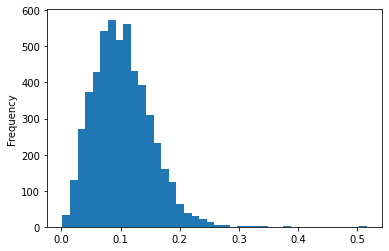

In [114]:
df_merge["Casos_per_capita"].plot.hist(bins=40)

<AxesSubplot:ylabel='Frequency'>

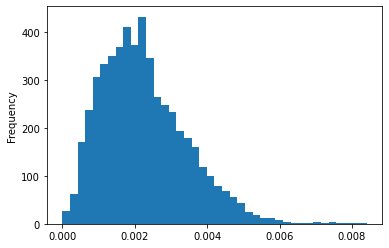

In [115]:
df_merge.loc[df_merge['Mortes_per_capita'] > 0.2,'Mortes_per_capita'] = np.nan
df_merge = df_merge.fillna(df_merge.mean())
df_merge["Mortes_per_capita"].plot.hist(bins=40)

<AxesSubplot:>

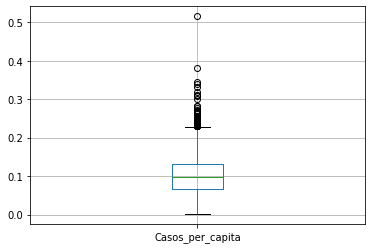

In [116]:
df_merge.boxplot(column=['Casos_per_capita'])

<AxesSubplot:>

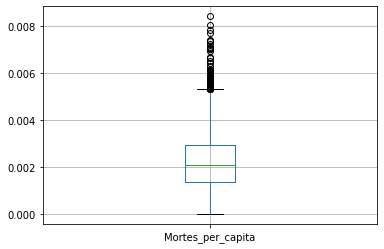

In [117]:
#df_merge['Mortes_per_capita'] = df_merge['Mortes_per_capita'].replace('1',df_merge['Mortes_per_capita'].mean())
df_merge.loc[df_merge['Mortes_per_capita'] > 0.2,'Mortes_per_capita'] = np.nan
df_merge = df_merge.fillna(df_merge.mean())
df_merge.boxplot(column=['Mortes_per_capita'])

<AxesSubplot:ylabel='Frequency'>

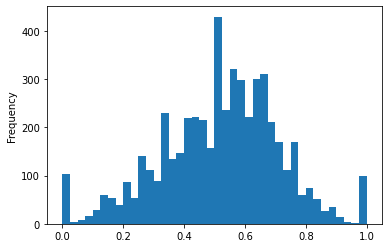

In [118]:
df_merge["Relacao_Presenca"].plot.hist(bins=40)

<AxesSubplot:>

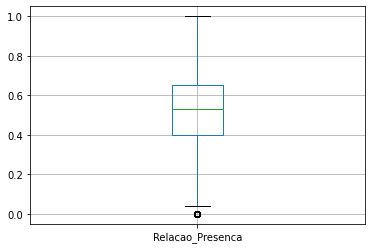

In [119]:
df_merge.boxplot(column=['Relacao_Presenca'])

In [122]:
corr = df_merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,Presente,Total_Alunos,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Casos_per_capita,Mortes_per_capita,Relacao_Presenca
Presente,1.000000,0.990566,0.928834,0.943609,0.451616,0.925124,0.218150,0.024566,0.107668,0.088357
Total_Alunos,0.990566,1.000000,0.923555,0.932115,0.413853,0.915586,0.197495,0.023293,0.108873,0.068634
populacaoTCU2019,0.928834,0.923555,1.000000,0.957317,0.432610,0.973655,0.179645,0.006080,0.095011,0.063739
casosAcumulado,0.943609,0.932115,0.957317,1.000000,0.402104,0.933725,0.214378,0.084812,0.140930,0.076626
casosNovos,0.451616,0.413853,0.432610,0.402104,1.000000,0.555929,0.208332,0.024171,0.073240,0.048786
obitosAcumulado,0.925124,0.915586,0.973655,0.933725,0.555929,1.000000,0.158869,0.024048,0.125831,0.056593
obitosNovos,0.218150,0.197495,0.179645,0.214378,0.208332,0.158869,1.000000,-0.000794,0.046008,0.036702
Casos_per_capita,0.024566,0.023293,0.006080,0.084812,0.024171,0.024048,-0.000794,1.000000,0.536707,0.003918
Mortes_per_capita,0.107668,0.108873,0.095011,0.140930,0.073240,0.125831,0.046008,0.536707,1.000000,-0.030649
Relacao_Presenca,0.088357,0.068634,0.063739,0.076626,0.048786,0.056593,0.036702,0.003918,-0.030649,1.000000
